In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

def fetch_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching data:", response.status_code, response.text)
        return None
    data = response.json()
    if 'results' not in data:
        print("No 'results' key in response:", data)
        return None
    return data

def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

def update_outliers_list(current_df, historical_outliers_df, real_time_outliers_df, n=10):
    if 'source' not in current_df.columns:
        current_df['source'] = 'real-time'
    combined_df = pd.concat([historical_outliers_df, current_df])
    updated_outliers_df = combined_df.nlargest(n, 'abs_daily_return')
    updated_historical_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'historical']
    updated_real_time_outliers_df = updated_outliers_df[updated_outliers_df['source'] == 'real-time']
    return updated_historical_outliers_df, updated_real_time_outliers_df

def convert_timestamps(df):
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    return df

def plot_data_with_outliers(full_df, historical_outliers_df, real_time_outliers_df, currency_pair):
    plt.figure(figsize=(14, 7))
    plt.plot(full_df['date'], full_df['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(historical_outliers_df['date'], historical_outliers_df['daily_return'], color='red', label='Historical Outliers')
    plt.scatter(real_time_outliers_df['date'], real_time_outliers_df['daily_return'], color='green', label='Latest Outliers', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title(f'Time Series of Daily Returns Highlighting Outliers for {currency_pair}')
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_currency_pair(currency_pair):
    api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'
    today = pd.Timestamp.now().date()
    start_date = today - pd.DateOffset(years=1)
    start_date_formatted = start_date.strftime('%Y-%m-%d')
    end_date = today - pd.DateOffset(days=1)
    end_date_formatted = end_date.strftime('%Y-%m-%d')
    historical_url = f'https://api.polygon.io/v2/aggs/ticker/C:{currency_pair}/range/1/day/{start_date_formatted}/{end_date_formatted}?adjusted=true&sort=asc&apiKey={api_key}'
    real_time_url = f'https://api.polygon.io/v2/aggs/ticker/C:{currency_pair}/range/1/day/{today}/{today}?adjusted=true&sort=asc&apiKey={api_key}'

    historical_data = fetch_data(historical_url)
    if historical_data:
        historical_df = pd.DataFrame(historical_data['results'])
        historical_df = convert_timestamps(historical_df)
        historical_df = calculate_daily_returns(historical_df)
        historical_df['source'] = 'historical'
        historical_outliers_df = get_top_outliers(historical_df)
    else:
        print(f"Failed to fetch or process historical data for {currency_pair}.")
        return

    real_time_data = fetch_data(real_time_url)
    if real_time_data and 'results' in real_time_data:
        real_time_df = pd.DataFrame(real_time_data['results'])
        real_time_df = convert_timestamps(real_time_df)
        last_close = historical_df['c'].iloc[-1] if not historical_df.empty else None
        real_time_df = calculate_daily_returns(real_time_df, prev_close=last_close)
        real_time_df['source'] = 'real-time'
        updated_historical_outliers_df, updated_real_time_outliers_df = update_outliers_list(real_time_df, historical_outliers_df, pd.DataFrame())
        historical_df = pd.concat([historical_df.iloc[1:], real_time_df])  # Keep historical data rolling
    else:
        print(f"No new data available or failed to fetch real-time data for {currency_pair}.")
        return

    full_df = pd.concat([historical_df, real_time_df])
    plot_data_with_outliers(full_df, updated_historical_outliers_df, updated_real_time_outliers_df, currency_pair)

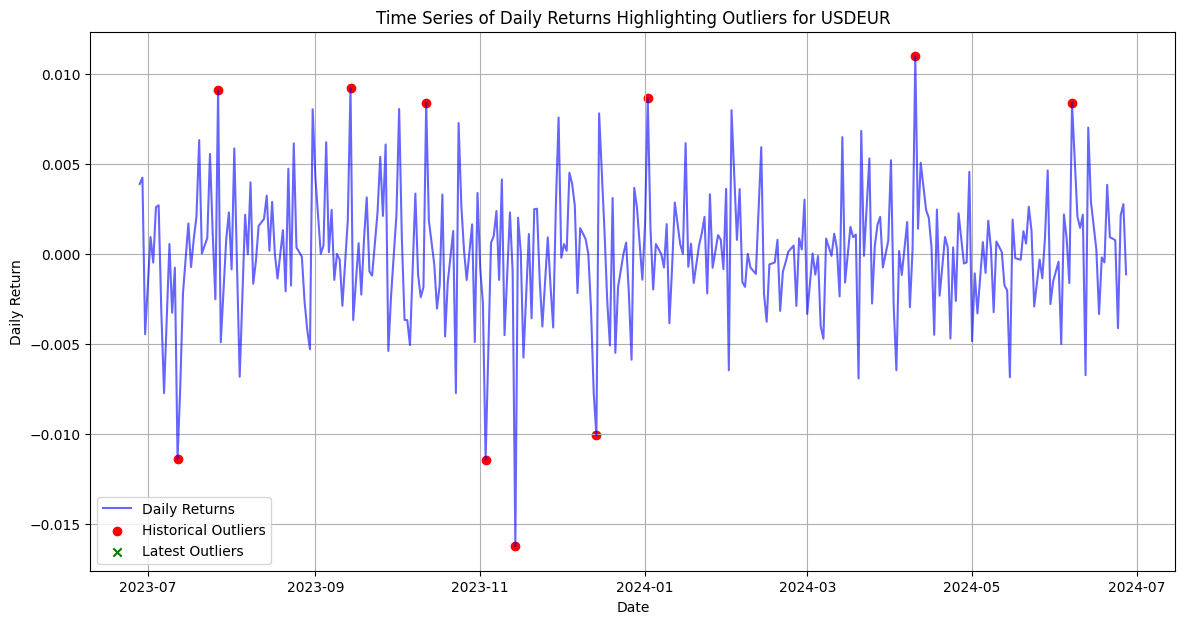

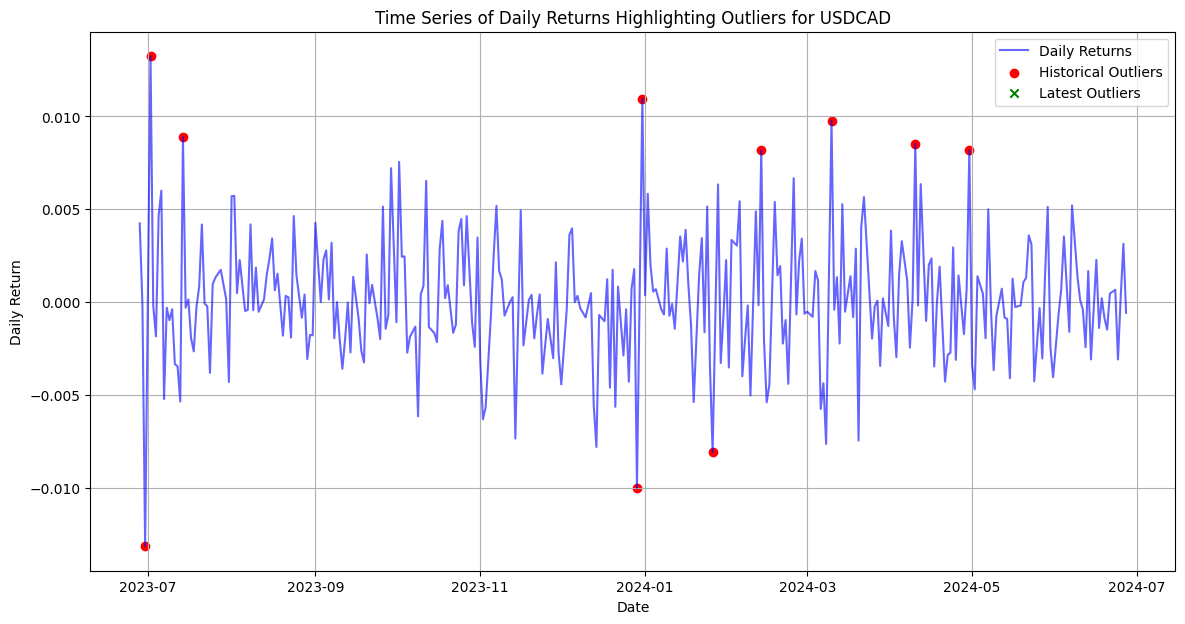

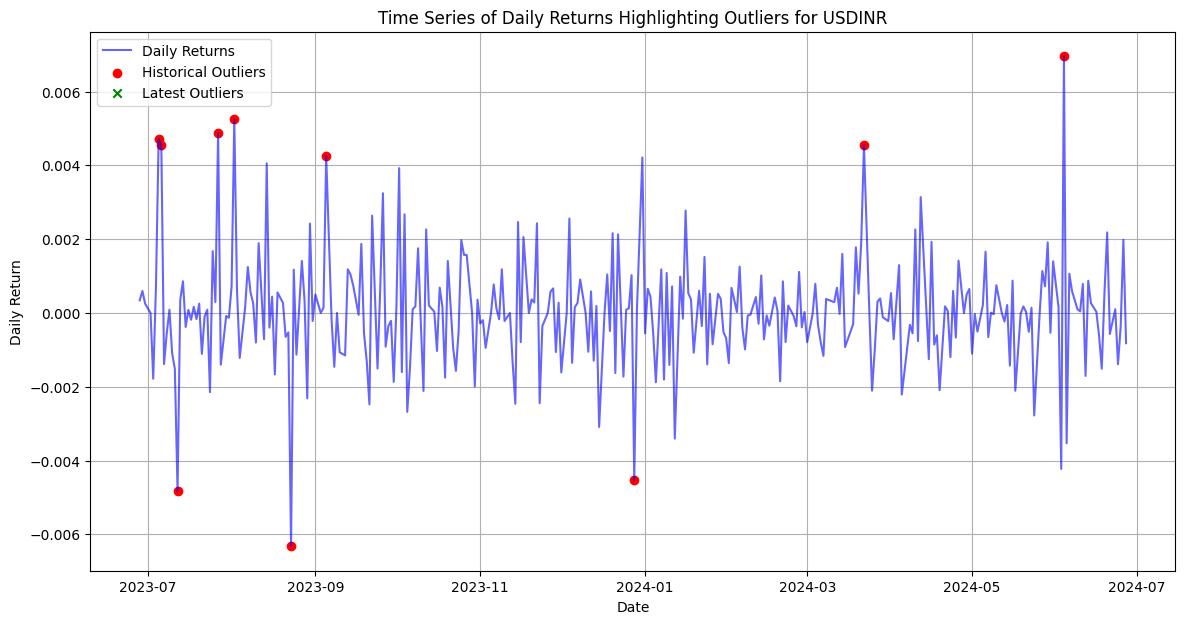

In [2]:
# List of currency pairs
currency_pairs = ['USDEUR', 'USDCAD', 'USDINR']

# Analyze each currency pair
for pair in currency_pairs:
    analyze_currency_pair(pair)